# ML Pipeline Modeling and Benchmarking
In this notebook we compare different ML models and engineered features for text classification applied on the Disaster Response pipeline using TFIDF.

We investigate the following approaches:
* Different ML algorithms: RandomForest, AdaBoost, SVM and Naive Bayes
* Additional Feature Engineering: Text length, message contains url / cardinal number
* Grid search applied on the above mentioned algorithms and additional features

In [1]:
# import libraries
import pandas as pd
from sqlalchemy import create_engine
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords', 'averaged_perceptron_tagger'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, \
                            f1_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\frank\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\frank\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\frank\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\frank\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('DisasterResponses', con = engine)

X = df['message']
Y = df.drop(columns=['id', 'message', 'original','genre'], axis=1)
print(X.shape)
print(Y.shape)

(26215,)
(26215, 36)


### 2.Tokenization function to process text data and function to perform benchmarks on pipelines

In [3]:
def tokenize(text):
    
    """
        splits text into clened tokens by removing stopwords, case normalizing and
        lemmatizing 
        
        Args:
            text           str            Text to be tokenized
            
        Returns:
            clean_token    list of str    list of cleaned tokens
        
    """
    
    # extract words
    tokens = word_tokenize(text)
    
    # remove stopwords
    tokens = [t for t in tokens if not t in stopwords.words('english')]

    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    
    for token in tokens:
        # normalize & lemmatize
        clean_token = lemmatizer.lemmatize(token).lower().strip()
        clean_tokens.append(clean_token)    
    
    return clean_tokens


def pipeline_benchmark(pipeline_list, X,Y, return_best_params=False):
    """
       Trains and benchmarks the ML pipelines contained in pipeline_list
       on the data X,Y

       Args:
          pipeline_list   list of dictionaries pairs of pipeline name and model
          X               pandas.DataFrame     Feature data
          Y               pandas.DataFrame     Label data

        Returns
          df_scores       pandas.DataFrame     Benchmark results on precision, recall, F1, accuracy
    """

    # Split data into train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    
    best_params_list = []

    df_scores = pd.DataFrame(columns=['Classifier', 'Precision' , 'Recall', 'F1-score', 'Accuracy-score', 'Accuracy-mean'])
    
    for pipeline in pipeline_list:
        # train pipeline
        pipeline['model'].fit(X_train, Y_train)
        if return_best_params:
            best_params_list.append(pipeline['model'].best_params_)
        Y_pred = pipeline['model'].predict(X_test)
        acc_mean = np.mean(Y_test.values==Y_pred)
        acc_score = accuracy_score(Y_test, Y_pred)
        prec_score = precision_score(Y_test, Y_pred, average='weighted')
        recall = recall_score(Y_test, Y_pred, average='weighted')
        f1 = f1_score(Y_test, Y_pred, average='weighted')
        df_scores = df_scores.append(pd.DataFrame({'Classifier': [pipeline['name']], 'Precision': [prec_score], 'Recall':[recall], \
                                               'F1-score':[f1], 'Accuracy-score':[acc_score], 'Accuracy-mean':[acc_mean]}), ignore_index=True)
    return df_scores, best_params_list


### 3. Build a machine learning pipeline
This machine pipeline should take in the message column as input and output classification results on the other 36 categories in the dataset. You may find the MultiOutputClassifier helpful for predicting multiple target variables.
We build four different pipeline applying four different ML algorithms and store them in a list of dictionaries to call the pipeline_benchmark function

In [4]:
# build the dictionaries for the 4 pipeline models
pipeline_definitions =[{'name':'Random Forest', 'classifier':RandomForestClassifier()},
                       {'name':'Ada Boost', 'classifier':AdaBoostClassifier()},
                       {'name':'SVM', 'classifier':OneVsRestClassifier(SVC())},
                       {'name':'Naive Bayes', 'classifier':MultinomialNB()}]
pipeline_list = []

for pipeline_def in pipeline_definitions:
    pipeline = Pipeline([
                     ('vect', CountVectorizer(tokenizer=tokenize)),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultiOutputClassifier(pipeline_def['classifier']))    
                  ])
    pipeline_list.append(dict(name=pipeline_def['name'], model=pipeline))

### 4. Train pipelines & test models
- Split data into train and test sets
- Train pipeline
- Report the f1 score, precision, recall and accuracy

All these steps are implemented in the pipeline_bechmark function

In [5]:
df_scores = pipeline_benchmark(pipeline_list, X, Y)

df_scores

C:\Users\frank\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\frank\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\frank\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\frank\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: Undef

(      Classifier  Precision    Recall  F1-score  Accuracy-score  Accuracy-mean
 0  Random Forest   0.767281  0.520754  0.560696        0.251875       0.947623
 1      Ada Boost   0.728436  0.574396  0.621264        0.251240       0.947454
 2            SVM   0.779908  0.561096  0.604282        0.298156       0.950692
 3    Naive Bayes   0.539227  0.371198  0.375510        0.163001       0.935502,
 [])

### Additional Feature Engineering
We will have a look on potential additional features:  
* message contains url (boolean)
* message contains cardinal number (boolean)
* at least one of the message sentence starts with a verb (boolean)
* text length of message (# of characters, # of words)

For each feature we expand the dataframe with one column each and check the distribution of these features over the different categories.


In [6]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def contains_url(text):
    detected_urls = re.findall(url_regex, text)
    if len(detected_urls) > 0:
        return True
    else:
        return False

def contains_number(text):   
    pos_tags = nltk.pos_tag(tokenize(text))
    for word, tag in pos_tags:
        if tag == 'CD':
            return True
    return False

def starting_verb(text):
    sentence_list = nltk.sent_tokenize(text)
    for sentence in sentence_list:
        pos_tags = nltk.pos_tag(tokenize(sentence))
        if len(pos_tags) > 0:
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
    return False

# expand dataframe with one column each for the defined features
df['contains_url'] = df['message'].apply(lambda x : contains_url(x))
df['contains_CD'] = df['message'].apply(lambda x : contains_number(x))
df['starting_verb'] = df['message'].apply(lambda x : starting_verb(x))
df['text_length'] = df['message'].apply(len)
df['text_length_word'] = df['message'].apply(lambda x: len(word_tokenize(x)))

In [7]:
# build a dataframe that contains for the boolean features the relative occurence of these 
# features in the 36 categories
features = ['contains_url', 'contains_CD', 'starting_verb']
df_feature_benchmark = pd.DataFrame(df.loc[:,'related':'direct_report'].columns, columns=['category'])

for feature in features:
    df_feature = pd.DataFrame(columns=['category', 'total_messages', 'messages_containing_feature', 'messages_containing_feature_rel'])

    for col in df.loc[:,'related':'direct_report'].columns:
        cat_total = df[col].sum()
        cat_contain_feature = df[(df[col]==1) & (df[feature] == 1)].shape[0]
        if cat_total > 0:
            cat_contain_feature_rel = cat_contain_feature/cat_total
        else:
            cat_contain_feature_rel = 0
        
        df_feature = df_feature.append({'category':col, 'total_messages':cat_total, \
                                      'messages_containing_feature':cat_contain_feature, \
                                      'messages_containing_feature_rel':cat_contain_feature_rel}, ignore_index=True)
    
    df_feature_benchmark = pd.concat([df_feature_benchmark, \
                                      pd.DataFrame(df_feature['messages_containing_feature_rel']).rename(columns={'messages_containing_feature_rel':feature})], axis=1)
    
    print('Feature: ', feature)
    print(df_feature.describe())
    print('\n')     

Feature:  contains_url
       messages_containing_feature_rel
count                        36.000000
mean                          0.027395
std                           0.020896
min                           0.000000
25%                           0.012875
50%                           0.023381
75%                           0.032328
max                           0.110111


Feature:  contains_CD
       messages_containing_feature_rel
count                        36.000000
mean                          0.412097
std                           0.101562
min                           0.000000
25%                           0.368824
50%                           0.439023
75%                           0.458491
max                           0.646566


Feature:  starting_verb
       messages_containing_feature_rel
count                        36.000000
mean                          0.046061
std                           0.025395
min                           0.000000
25%                           

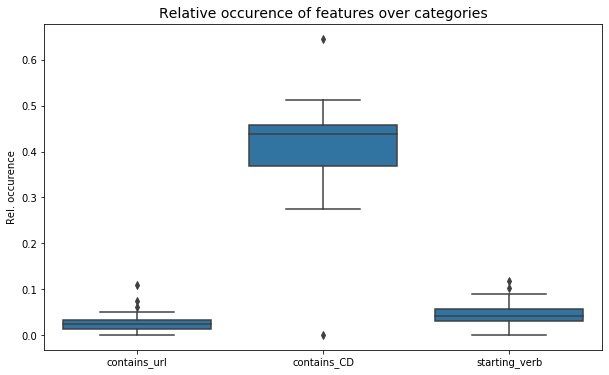

In [8]:
# create boxplots to illustrate the spread of the relative ocurrence per feature 
fig, ax = plt.subplots(figsize=(10,6))
basecolor = sns.color_palette()[0]
sns.boxplot(data=df_feature_benchmark, color = basecolor )
ax.set_title('Relative occurence of features over categories', fontsize=14)
ax.set_ylabel('Rel. occurence')
ax.set_xlabel('');

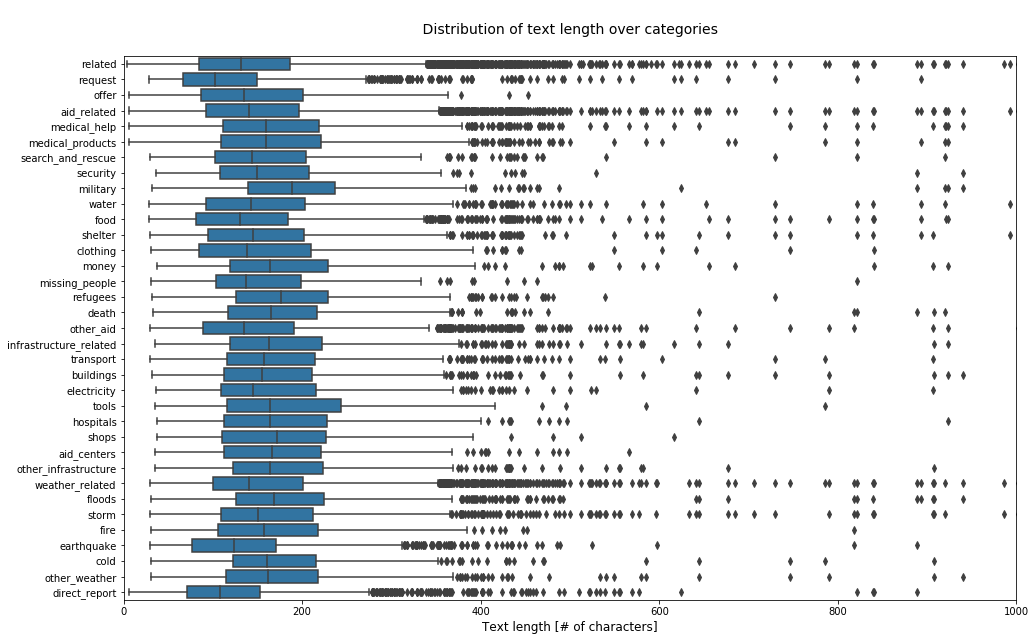

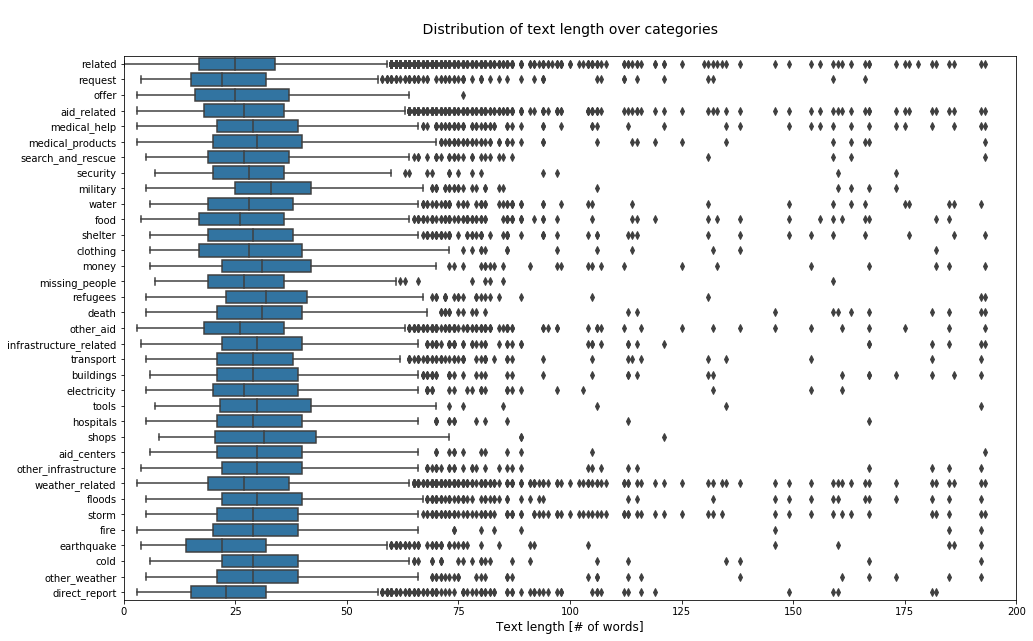

In [9]:
# for the conitnuous features we have to create boxplots per category
features = ['text_length', 'text_length_word']

for feature in features:
    df_feature = pd.DataFrame(columns=['category',feature])
    for col in df.loc[:,'related':'direct_report'].columns:
        df_extract = pd.DataFrame(df[df[col]==1][feature])
        if df_extract.shape[0] > 0:
            df_feature = df_feature.append(pd.DataFrame({'category':pd.DataFrame([col]*df_extract.shape[0], columns=['cat']).cat.values.tolist(),\
                                       feature:df_extract[feature].values.tolist()}), ignore_index=True)
         
    fig, ax = plt.subplots(figsize=(16,10))
    basecolor = sns.color_palette()[0]
    sns.boxplot(data=df_feature, y='category', x=feature, color=basecolor)
    ax.set_title('\n Distribution of text length over categories \n', fontsize=14)
    ax.set_ylabel('')
    if feature == 'text_length':
        ax.set_xlabel('Text length [# of characters]', fontsize=12)
        ax.set_xlim([0,1000]) 
    else:
        ax.set_xlabel('Text length [# of words]', fontsize=12)
        ax.set_xlim([0,200])       

**Conclusion:**

The feature "containing cardinal number" shows the widest spread amaong the categories and looks most promising to imporve the quality of the model

### 5. Improve the model
* Use grid search to find better parameters for the different ML algorithms.
* Furthermore, the feature "Containing cardinal number" is added to the pipeline

In [10]:
# Defintion of class to use the additional feature "contains cardinal number"
# in the ML pipeline
class ContainingNumberExtractor(BaseEstimator, TransformerMixin):

    def containing_number(self, text):   
        pos_tags = nltk.pos_tag(tokenize(text))
        for word, tag in pos_tags:
            if tag == 'CD':
                return True
        return False

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.containing_number)
        return pd.DataFrame(X_tagged)

In [11]:
# build the dictionaries for the 4 GridSearch pipeline models
# this time we have to define in addition the hyperparameter search space 
params_rf_ada = {
    'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
    'features__text_pipeline__tfidf__norm': ['l1', 'l2'],
    'clf__estimator__n_estimators': [50, 100, 200],
}

params_svc = {
    'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
    'features__text_pipeline__tfidf__norm': ['l1', 'l2'],
    'clf__estimator__estimator__kernel': ['linear', 'rbf'],
}

params_nb = {
    'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
    'features__text_pipeline__tfidf__norm': ['l1', 'l2'],
    'clf__estimator__alpha': [0.5, 1.0],
}


pipeline_definitions =[{'name':'Random Forest', 'classifier':RandomForestClassifier(), 'params':params_rf_ada},
                       {'name':'Ada Boost', 'classifier':AdaBoostClassifier(), 'params':params_rf_ada},
                       {'name':'SVM', 'classifier':OneVsRestClassifier(SVC()), 'params':params_svc},
                       {'name':'Naive Bayes', 'classifier':MultinomialNB(), 'params':params_nb}]

pipeline_list = []

for pipeline_def in pipeline_definitions:

    pipeline = Pipeline([
      ('features', FeatureUnion([
          ('text_pipeline', Pipeline([
              ('vect', CountVectorizer(tokenizer=tokenize)),
              ('tfidf', TfidfTransformer())                                     
          ])),
          ('containing_number', ContainingNumberExtractor())                                          
      ])),
      ('clf', MultiOutputClassifier(pipeline_def['classifier']))
    ])   
    
    cv = GridSearchCV(pipeline, param_grid=pipeline_def['params'], verbose=3, n_jobs=3)
    pipeline_list.append(dict(name=pipeline_def['name'], model=cv))

In [12]:
df_scores, best_params_list  = pipeline_benchmark(pipeline_list, X, Y, return_best_params=True)

df_scores

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 106.5min
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed: 348.4min finished
C:\Users\frank\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\frank\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\frank\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 79.7min
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed: 234.5min finished
C:\Users\frank\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\frank\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\frank\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true n

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 279.8min
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed: 514.3min finished
C:\Users\frank\Anaconda3\lib\site-packages\sklearn\multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
C:\Users\frank\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\frank\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\frank\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is il

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 54.4min
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed: 83.4min finished
C:\Users\frank\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\frank\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\frank\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true no

,Classifier,Precision,Recall,F1-score,Accuracy-score,Accuracy-mean
0,Random Forest,0.764857,0.496484,0.546002,0.264336,0.946521
1,Ada Boost,0.720281,0.581750,0.629862,0.264590,0.947369
2,SVM,0.762571,0.592719,0.637009,0.315321,0.951971
3,Naive Bayes,0.381635,0.248403,0.222292,0.198220,0.927333


In [13]:
best_params_list

[{'clf__estimator__n_estimators': 200,
  'features__text_pipeline__tfidf__norm': 'l1',
  'features__text_pipeline__vect__ngram_range': (1, 2)},
 {'clf__estimator__n_estimators': 100,
  'features__text_pipeline__tfidf__norm': 'l2',
  'features__text_pipeline__vect__ngram_range': (1, 1)},
 {'clf__estimator__estimator__kernel': 'linear',
  'features__text_pipeline__tfidf__norm': 'l2',
  'features__text_pipeline__vect__ngram_range': (1, 1)},
 {'clf__estimator__alpha': 1.0,
  'features__text_pipeline__tfidf__norm': 'l1',
  'features__text_pipeline__vect__ngram_range': (1, 2)}]

###### Final conclusion:
* Support Vector Machine model shows the best performance and will thus be considered in the Disaster Response pipeline